# Big Data Project - Xiachufang（下厨房）

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import json
import jieba
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
from plotly.offline import iplot
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs import Bar
import plotly.offline as off
from sklearn.manifold import TSNE

# 1. 24-hour pop recipes in Xiachufang

In [ ]:
url_page1='https://www.xiachufang.com/activity/site/?order=pop&page='
urls = []
for i in range(1,51):
    url = url_page1 + str(i)
    urls.append(url)

def get_one_page(url):
    r = requests.get(url)
    mypage = bs4.BeautifulSoup(r.text, 'lxml')
    mycooks = mypage.find_all('div', attrs={'class': 'dish-280'})


    cooks = []
    for mycook in mycooks:
    
        title = mycook.find('p',attrs={'name ellipsis red-font'}).find('a').text
        desc = mycook.find('p',attrs={'desc'}).text
        time = mycook.find('p',attrs={'pure-u-1-2'}).text
        like = mycook.find('span',attrs={'n-diggs'}).text
        comment = mycook.find('span',attrs={'n-comments'}).text
        user = mycook.find('div',attrs={'author clearfix ellipsis'}).find('a').text.strip()
        location = mycook.find('span',attrs={'location gray-font'})
        if location == None:
            location = location 
        else:
            location = location.text.strip()
            
    
        cooks.append([title,desc,time,like,comment,user,location])
    
    return cooks

all_cooks = []
for url in urls:
    all_cooks.extend(get_one_page(url))

df = pandas.DataFrame(all_cooks, columns=['title','desc','time','like',
                                      'comment','user','location'])
#df
#location =df['location'].value_counts().plot(kind='bar')
#location

all_location = []
for x in df['location']:
    if x == None:
        all_location.append(x)
    else:
        all_location.append(x[1:3])
df['location'] = all_location

s = df['location'].value_counts()
d = s.to_frame().reset_index().rename(columns={'index': 'name', 'location': 'value'})
list(d.T.to_dict().values())

Based on location data, we plot user disribution map of China which can be viewed in ppt.

# 2. Monthly pop recipes in Xiachufang

In [ ]:
url_one = 'https://www.xiachufang.com/explore/?page='
urls = []
for i in range(1,40):
    url = url_one + str(i)
    urls.append(url)
    
all_names = []
all_hots = []
all_authors=[]
all_materials=[]


for url in urls:
    pages = BeautifulSoup(requests.get(url).text)

    
    names = []
    for n in pages.find_all('p', attrs={'class':'name'}):
        names.append(n.text.strip())
        
        
    authors = []
    for a in pages.find_all('p', attrs={'class':'author'}):
        authors.append(a.text.strip())
        
    
    hots = []
    for h in pages.find_all('span', attrs={'class': 'bold'}):
        hots.append(h.text)
        
        
    materials=[]
    for m in pages.find_all('p', attrs={'class':'ing ellipsis'}):
        materials.append(m.text.strip())
    
   
    
    all_names.extend(names)
    all_hots.extend(hots)
    all_authors.extend(authors)
    all_materials.extend(materials)
    
    
    for index,item in enumerate(all_hots):
        all_hots [index] = int(item)
#str轉整型
    
with open('monthly pop recipes.csv','w') as f:
    writer = csv.writer(f)
    header = ['names','hots','authors','materials']
    writer.writerow(header)
    writer.writerows(zip(all_names,all_hots,all_authors,all_materials))

In [2]:
df= pd.read_csv("monthly pop recipes.csv")
#df
#七天之內最熱門的菜譜 包括名稱，有多少人做過，發布者，菜譜

In [3]:
rank = df.sort_values(by = ['hots'],ascending=False)
#rank
#按照熱度（七天內多少人做過 排序）

In [4]:
data = [go.Bar(
    
            x=rank['names'],
            y=rank['hots'][:10],
            marker= dict(
            color=['rgba(222,45,38,0.8)','rgba(204,204,204)', 
               'rgba(204,204,204)', 'rgba(204,204,204)',
               'rgba(204,204,204)','rgba(204,204,204)','rgba(222,45,38,0.8)','rgba(204,204,204)', 
               'rgba(204,204,204)', 'rgba(204,204,204)', 'rgba(204,204,204)'])
    )]

iplot({"data":data,
     "layout":Layout(title = "Top 10 in a Week")})

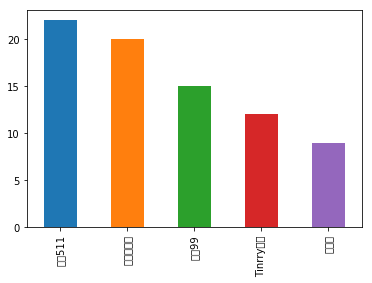

In [5]:
au=df['authors'].value_counts()[:5].plot(kind='bar')
#au.reset_index()
#出現頻率最高的作者
#au
#由于作者名称为中文，后期利用ps标注

In [6]:
all_ma=df['materials'].value_counts().index
#all_ma

In [7]:
all_ma=[]
for material in df['materials']:
    m=list(jieba.cut(material))
    all_ma.extend(m)
#all_ma

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/sk/fp6ry8ss3md7gdyr3b1qcnb80000gn/T/jieba.cache
Loading model cost 1.317 seconds.
Prefix dict has been built succesfully.


In [9]:
ma_count={}
for material in all_ma:
    if material not in ma_count:
        ma_count[material] = 1
    else:
        ma_count[material] = ma_count[material]+1
#ma_count

# 3. Foreign recipes in Xiachufang

In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('1_dongnanya_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(1,11):
        url = 'https://www.xiachufang.com/category/51965/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件




if __name__ == '__main__':
    result_list = []
    main()


In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('2_korean_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(10):
        url = 'https://www.xiachufang.com/category/40080/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件
    


if __name__ == '__main__':
    result_list = []
    main()

In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('3_japanese_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(10):
        url = 'https://www.xiachufang.com/category/40081/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件
    


if __name__ == '__main__':
    result_list = []
    main()

In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('4_western_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(10):
        url = 'https://www.xiachufang.com/category/51305/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件
    


if __name__ == '__main__':
    result_list = []
    main()

In [10]:
#用Pandas打开东南亚、韩式、日式、西式菜系
with open('1_dongnanya_hot.json', 'r') as f1:
    data1 = json.load(f1)
df1 = pd.DataFrame(data1)

with open('2_korean_hot.json', 'r') as f2:
    data2 = json.load(f2)
df2 = pd.DataFrame(data2)

with open('3_japanese_hot.json', 'r') as f3:
    data3 = json.load(f3)
df3 = pd.DataFrame(data3)

with open('4_western_hot.json', 'r') as f4:
    data4 = json.load(f4)
df4 = pd.DataFrame(data4)

dfs = [df1, df2, df3,df4]

In [11]:
#把热门程度从字符串变成数字类型
all_hot = []
for x in df1['hot']:
    all_hot.append(float(x))
    
df1['hot']=all_hot
#df1.sort_values(by = ['hot'], ascending = False)

all_hot_2 = []
for x in df2['hot']:
    all_hot_2.append(float(x))
    
df2['hot']=all_hot_2

all_hot_3 = []
for x in df3['hot']:
    all_hot_3.append(float(x))
    
df3['hot']=all_hot_3

all_hot_4 = []
for x in df4['hot']:
    all_hot_4.append(float(x))
    
df4['hot']=all_hot_4

In [12]:
#把评分从字符串变成数字类型
all_rate = []
for x in df1['rate']:
    all_rate.append(float(x))
   
df1['rate']=all_rate

all_rate_2 = []
for x in df2['rate']:
    all_rate_2.append(float(x))
   
df2['rate']=all_rate_2

all_rate_3 = []
for x in df3['rate']:
    all_rate_3.append(float(x))
   
df3['rate']=all_rate_3

all_rate_4 = []
for x in df4['rate']:
    all_rate_4.append(float(x))
   
df4['rate']=all_rate_4


In [13]:
all_rate = []
for x in df1['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate.append(x)

df1['rate'] = all_rate

all_rate_2 = []
for x in df2['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate_2.append(x)

df2['rate'] = all_rate_2

all_rate_3 = []
for x in df3['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate_3.append(x)

df3['rate'] = all_rate_3

all_rate_4 = []
for x in df4['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate_4.append(x)

df4['rate'] = all_rate_4

In [14]:
# 东南亚、韩式、日式、西式菜谱年度热门趋势图
# The Hot Trend of Southeastern, Korean, Japanese and Western Recipes

df1_hot = df1.sort_values(by = 'time', ascending = False)
data_trend1 = [go.Scatter(
    x = df1_hot['time'],
    y = df1_hot['hot'].values,
    mode = 'lines+markers',
    name = 'lines+markers',
    text = df1_hot['name'],
    marker=dict(
        color='rgb(255,168,52)',
        line=dict(
            color='rgb(8,48,107)'
        )
    ),

)]

layout = dict(title = 'Hot of Southeast Asia Recipes',
              xaxis= dict(
                title= 'Time',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_trend1, layout=layout)
iplot(fig)


In [15]:
df1.sort_values(by='hot',ascending = False)[:10]

,hot,name,rate,time
2,2197.0,泰式咖喱饭,8.5,2012-06-02 19:01:26
22,1566.0,南洋雪花糕,8.4,2011-10-14 20:59:11
0,1488.0,越南春卷,7.6,2012-08-23 17:52:17
80,1399.0,泰式咖喱虾,7.7,2011-10-16 02:31:20
9,888.0,泰式菠萝鸡饭,7.9,2011-12-23 16:09:42
50,836.0,冬阴功汤,6.8,2011-12-13 12:43:38
69,686.0,菠萝芝士小甜点,8.4,2012-12-03 16:32:52
41,574.0,泰式冬阴功汤火锅,7.9,2012-05-05 17:03:29
7,524.0,泰式椰浆咖喱鸡,7.8,2012-09-05 23:18:36
172,431.0,冬阴功汤,7.4,2011-03-01 17:50:13


In [16]:
df2_hot = df2.sort_values(by = 'time', ascending = False)
data_trend2 = [go.Scatter(
    x = df2_hot['time'],
    y = df2_hot['hot'].values,
    mode = 'lines+markers',
    name = 'lines+markers',
    text = df2_hot['name'],
    marker=dict(
        color='rgb(232,74,12)',
        line=dict(
            color='rgb(8,48,107)'
        )
    ),

)]

layout = dict(title = 'Trend of Korean Recipes',
              xaxis= dict(
                title= 'Time',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_trend2, layout=layout)
iplot(fig)

In [17]:
df2.sort_values(by='hot',ascending = False)[:10]

,hot,name,rate,time
48,6760.0,韩式辣炒年糕（or网红芝士套路之芝心年糕）,7.9,2014-02-08 06:39:38
47,4341.0,韩式南瓜粥,8.0,2011-06-05 22:09:00
24,3685.0,韩式紫菜包饭,7.9,2011-03-27 12:58:54
49,3540.0,韩式芝士部队锅,7.8,2012-11-13 21:23:51
6,3427.0,韩式烤五花肉,8.3,2014-05-26 19:53:05
11,3372.0,韩式拌饭,7.9,2011-11-02 17:14:18
33,3062.0,韩式南瓜粥,8.1,2013-04-11 18:00:05
38,2394.0,韩式辣炒年糕,7.4,2012-12-12 20:45:55
0,1995.0,韩国部队锅拉面锅（超好吃）,8.1,2015-03-26 02:04:27
18,1986.0,韩式土豆饼（好吃又营养）,7.1,2013-10-24 15:32:30


In [18]:
df3_hot = df3.sort_values(by = 'time', ascending = False)
data_trend3 = [go.Scatter(
    x = df3_hot['time'],
    y = df3_hot['hot'].values,
    mode = 'lines+markers',
    name = 'lines+markers',
    text = df3_hot['name'],
    marker=dict(
        color='rgb(255,0,0)',
        line=dict(
            color='rgb(8,48,107)'
        )
    ),
)]

layout = dict(title = 'Trend of Japanese Recipes',
              xaxis= dict(
                title= 'Time',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_trend3, layout=layout)
iplot(fig)

In [19]:
df3.sort_values(by='hot',ascending = False)[:10]

,hot,name,rate,time
12,12162.0,日式咖喱鸡饭！！最正宗日本家庭做法！简单又好吃！,8.6,2012-10-21 18:09:03
60,10881.0,日式香浓炼乳面包,8.6,2014-11-03 20:49:26
119,5782.0,日本棉花蛋糕,7.9,2013-07-31 23:26:52
19,4782.0,日式豆乳盒子蛋糕,7.7,2016-12-13 17:09:04
16,4662.0,日式红豆包,8.5,2016-03-06 23:53:45
178,4544.0,不易消泡的日式方法，可可海绵蛋糕百战宝典,8.4,2013-12-12 21:00:10
6,3926.0,超正宗日式蛋包饭,7.8,2014-02-22 20:48:09
27,3910.0,日式照烧鸡腿,7.7,2011-02-16 18:50:24
114,3682.0,日式芝士蛋糕,8.2,2011-11-06 16:49:16
85,3074.0,日式棉花蛋糕卷,8.5,2012-05-07 14:15:21


In [20]:
df4_hot = df4.sort_values(by = 'time', ascending = False)
data_trend4 = [go.Scatter(
    x = df4_hot['time'],
    y = df4_hot['hot'].values,
    mode = 'lines+markers',
    name = 'lines+markers',
    text = df4_hot['name'],
    marker=dict(
        color='rgb(129,13,255)',
        line=dict(
            color='rgb(8,48,107)'
        )
    ),
)]

layout = dict(title = 'Trend of Western Recipes',
              xaxis= dict(
                title= 'Time',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_trend4, layout=layout)
iplot(fig)

In [21]:
df4.sort_values(by='hot',ascending = False)[:10]

,hot,name,rate,time
2,472.0,菲力牛排（完整版快捷方便的西餐）,8.1,2014-04-20 18:46:54
27,403.0,好吃简单的西餐--芝士焗意面,7.6,2014-12-15 21:52:24
39,233.0,西式乳酪欧姆蛋 omelette,7.6,2012-08-20 04:20:21
69,190.0,西式炒蛋,8.4,2011-10-25 13:59:40
60,183.0,Scrambled Eggs（西式黄油炒蛋）,8.0,2012-05-24 20:54:14
56,176.0,核桃南瓜意面/通心粉<全世界最简单的西餐>,8.8,2016-08-03 15:19:28
4,117.0,西式浓汤,8.2,2014-05-10 15:30:27
135,107.0,【曼达小馆】松松软软还带奶香的西式大馒头：牛奶吐司,7.7,2017-05-17 11:47:23
13,80.0,特别好吃的一道西餐菜-奶酪香烤番茄盅,7.5,2013-03-25 16:24:53
29,80.0,本格西式鸡胸肉,8.8,2015-07-20 23:52:33


In [22]:
# 东南亚、韩式、日式、西式菜谱评分和热度对比图
# The Comparision between Rate and Hot of Southeastern, Korean, Japanese and Western Recipes

data_rate1 = [go.Scatter(
    x = df1['rate'],
    y = df1['hot'],
    mode = 'markers',
    name = 'markers',
    text = df1['name'],
    marker=dict(
        color='rgb(255,168,52)',
        line=dict(
            color='rgb(255,168,52)',
            width = 5
        )
    )
)]
    
layout = dict(title = 'Rate and Hot of Southeast Asia Recipes',
              xaxis= dict(
                title= 'Rate',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_rate1, layout=layout)
iplot(fig)

In [23]:
data_rate2 = [go.Scatter(
    x = df2['rate'],
    y = df2['hot'],
    mode = 'markers',
    name = 'markers',
    text = df2['name'],
    marker=dict(
        color='rgb(232,74,12)',
        line=dict(
            color='rgb(232,74,12)',
            width = 5
        )
    )
)]
    
layout = dict(title = 'Rate and Hot of Korean Recipes',
              xaxis= dict(
                title= 'Rate',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_rate2, layout=layout)
iplot(fig)

In [24]:
data_rate3 = [go.Scatter(
    x = df3['rate'],
    y = df3['hot'],
    mode = 'markers',
    name = 'markers',
    text = df3['name'],
    marker=dict(
        color='rgb(255,0,0)',
        line=dict(
            color='rgb(255,0,0)',
            width = 5
        )
    )
)]
    
layout = dict(title = 'Rate and Hot of Japanese Recipes',
              xaxis= dict(
                title= 'Rate',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_rate3, layout=layout)
iplot(fig)

In [25]:
data_rate4 = [go.Scatter(
    x = df4['rate'],
    y = df4['hot'],
    mode = 'markers',
    name = 'markers',
    text = df4['name'],
    marker=dict(
        color='rgb(129,13,255)',
        line=dict(
            color='rgb(129,13,255)',
            width = 5
        )
    )
)]
    
layout = dict(title = 'Rate and Hot of Western Recipes',
              xaxis= dict(
                title= 'Rate',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Hot(unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )

fig = dict(data=data_rate4, layout=layout)
iplot(fig)

# 4. Network of Chinese recipes in Xiachufang

In [27]:
with open('cooking_xiang.json', 'r') as f:
    data1 = json.load(f)
df1 = pd.DataFrame(data1)
df1['colour']=0

with open('cooking_hui.json', 'r') as f:
    data2 = json.load(f)
df2 = pd.DataFrame(data2)
df2['colour']=1

with open('cooking_lu.json', 'r') as f:
    data3 = json.load(f)
df3 = pd.DataFrame(data3)
df3['colour']=2

with open('cooking_min.json', 'r') as f:
    data4 = json.load(f)
df4 = pd.DataFrame(data4)
df4['colour']=3

with open('cooking_su.json', 'r') as f:
    data5 = json.load(f)
df5 = pd.DataFrame(data5)
df5['colour']=4

with open('cooking_yue.json', 'r') as f:
    data6 = json.load(f)
df6 = pd.DataFrame(data6)
df6['colour']=5

with open('cooking_zhe.json', 'r') as f:
    data7 = json.load(f)
df7 = pd.DataFrame(data7)
df7['colour']=6

with open('cooking_chuan.json', 'r') as f:
    data8 = json.load(f)
df8 = pd.DataFrame(data8)
df8['colour']=7

df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8], ignore_index=True)
df.drop_duplicates(subset=None, keep='first', inplace=False).head()

,material,name,recipe,colour
0,尖辣椒\n\n \n\n ...,辣椒炒肉,辣椒洗净，滚刀切，切完再洗一遍，滤掉多余的辣椒籽！\n\n\n\n猪肉切条，并用一克白糖和5...,0
1,鸡心\n\n\n\n\n\n\n鸡肝\n\n\n\n\n\n\n鸡胗\n\n\n\n\n\n...,湘菜10《酸辣鸡杂》,腌制鸡杂鸡心，鸡胗，鸡旰，鸡肠，改刀后加盐，料洒，白胡椒粉，鸡精抓匀，加淀粉抓匀码味。\n\...,0
2,豆腐\n\n\n 250克\n ...,湘味农家豆腐,韭菜切小段，大蒜切碎备用。肉末用少许料酒和酱油和油腌制5分钟。\n\n\n豆腐切块入锅双面煎...,0
3,鸡蛋\n\n\n\n\n\n\n杭椒\n\n\n\n\n\n\n ...,金钱蛋-经典湘菜,鸡蛋煮熟，一般一个菜是3-4枚。\n\n\n\n剥壳，切0.5cm厚样子。切的时候用水果刀不...,0
4,大鱼头\n\n \n\n\n\n\n\n剁椒\n\n\n\n\...,湘菜07《剁椒鱼头》,鱼头码味。胖头鱼中间切开两片，不要切断，肉厚的部分剞上花刀，鱼骨斩断。葱花姜片放在料酒中泡一...,0


In [28]:
a_m=[]
for i in open('material_list.txt'):
    i=i.strip('\n')
    a_m.append(i)
len(a_m)

1389

In [29]:
def get_material_value1(v):
    temp_data = []
    for r in a_m:
        if r in v:
            temp_data.append(1)
        else:
            temp_data.append(0)
    return temp_data

In [30]:
df['material-value'] = df['recipe'].apply(get_material_value1)

In [31]:
A = list(df['material-value'].values)
len(A)

1497

In [32]:
X = np.array(A)

In [33]:
X = np.array(A)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1497, 2)

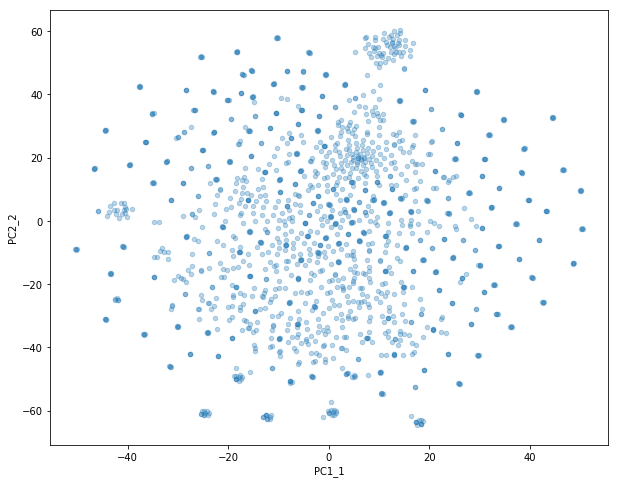

In [34]:
df['PC1_1'] = X_embedded.T[0]
df['PC2_2'] = X_embedded.T[1]
df.plot('PC1_1', 'PC2_2', kind='scatter', alpha=0.3, figsize=(10,8))

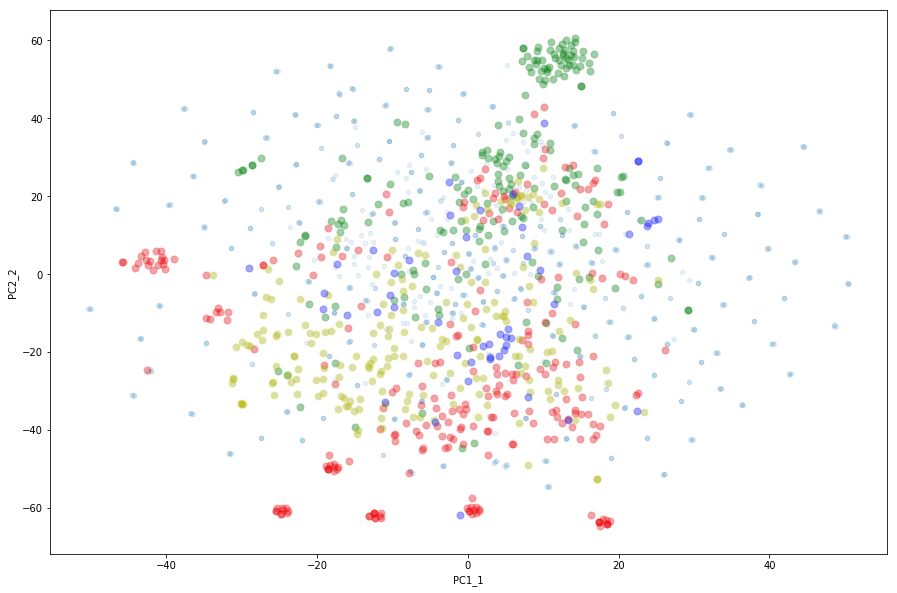

In [36]:
myax = df.plot('PC1_1', 'PC2_2', kind='scatter', alpha=0.1, figsize=(15,10))
df[df['colour']==5].plot('PC1_1', 'PC2_2', kind='scatter', color='green', ax=myax, alpha=0.3, s=50)
df[df['colour']==7].plot('PC1_1', 'PC2_2', kind='scatter', color='red', ax=myax, alpha=0.3, s=50)
df[df['colour']==0].plot('PC1_1', 'PC2_2', kind='scatter', color='y', ax=myax, alpha=0.3, s=50)
df[df['colour']==2].plot('PC1_1', 'PC2_2', kind='scatter', color='b', ax=myax, alpha=0.3, s=50)

# 绿色代表粤菜，黄色代表湘菜，红色代表川菜，蓝色代表鲁菜

In [37]:
df_B=df[
    (df['PC1_1'] <-38)
    &
    (df['PC2_2'] > 0) & (df['PC1_2'] < 20)
]#value_counts()
#df_B 泡菜

In [40]:
df_C=df[
    (df['PC1_1'] > 0)&(df['PC1_1'] < 20)
    &
    (df['PC2_2'] > 50) 
]#['colour'].value_counts()
#df_C广式月饼